In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader

from dataloader import trainloader
from models.base_hovernet import targets


import os
import argparse
import importlib
from glob import glob
from tqdm import tqdm

from config import normal_Config, uniform_Config
from termcolor import colored
from collections import OrderedDict
from models.base_hovernet.utils import crop_to_shape, dice_loss, mse_loss, msge_loss, xentropy_loss


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = trainloader.FileLoader(
        glob(os.path.join(normal_Config['train_dataset_path'], '*.npy')),     
        mode=normal_Config['run_mode'],
        with_type=normal_Config['with_type'],
        setup_augmentor=True, # 이거 True / False 차이 알아보기
        target_gen=[targets.gen_targets, {}],
        **normal_Config['shape_info'][normal_Config['run_mode']]
    )
train_loader = DataLoader(
    train_dataset,
    num_workers=2,
    batch_size=normal_Config['batch_size'],
    shuffle=normal_Config['run_mode'] == "train",
    drop_last=normal_Config['run_mode'] == "train",
    # worker_init_fn=worker_init_fn, # TODO: multiGPU에서 
)
    

KeyError: 'train_dataset_path'

In [6]:
for key, value in train_dataset[0].items():
    print(f'{key}: {value.shape}')

img: (270, 270, 3)
tp_map: (80, 80)
hv_map: (80, 80, 2)
np_map: (80, 80)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2  # OpenCV 추가 (사각형 그리기용)

def cropping_center(img, crop_shape):
    """Center crops an image to the desired size."""
    h, w = img.shape[:2]
    new_h, new_w = crop_shape

    top = (h - new_h) // 2
    left = (w - new_w) // 2

    return img[top:top+new_h, left:left+new_w], (left, top, new_w, new_h)

def overlay_images(base_img, overlay_img, alpha=0.5):
    """Overlay two images with a specified transparency level (alpha)."""
    overlay_img_resized = cv2.resize(overlay_img, (base_img.shape[1], base_img.shape[0]))
    overlay_img_colored = cv2.applyColorMap((overlay_img_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    
    overlayed = cv2.addWeighted(base_img, 1 - alpha, overlay_img_colored, alpha, 0)
    return overlayed

def visualize_sample(dataset, index):
    sample = dataset[index]
    
    img = sample['img']
    tp_map = sample['tp_map']
    hv_map = sample['hv_map']
    np_map = sample['np_map']

    # 이미지 Center Crop (80, 80)
    img_cropped, crop_info = cropping_center(img, (80, 80))
    np_cropped, _ = cropping_center(np_map, (80, 80))  # np_map도 동일하게 crop
    
    # Crop 위치 정보 (x, y, width, height)
    left, top, new_w, new_h = crop_info
    
    # 원본 이미지에 빨간 사각형 표시 (사각형 그리기)
    img_with_rect = img.copy()
    img_with_rect = cv2.rectangle(
        img_with_rect, 
        (left, top), 
        (left + new_w, top + new_h), 
        (255, 0, 0), # 빨간색 (BGR)
        2 # 두께
    )
    
    # hv_map을 h와 v로 분리
    h_map = hv_map[..., 0]
    v_map = hv_map[..., 1]

    # Overlayed image 생성
    overlay_img = overlay_images(img_cropped, np_cropped, alpha=0.5)
    
    fig, axes = plt.subplots(1, 7, figsize=(30, 5))
    
    # 1. Original 이미지 (빨간 사각형 포함)
    axes[0].imshow(cv2.cvtColor(img_with_rect, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original img (270x270)')
    axes[0].axis('off')
    
    # 2. Center Cropped 이미지
    axes[1].imshow(img_cropped)
    axes[1].set_title('Cropped img (80x80)')
    axes[1].axis('off')
    
    # 3. Overlayed 이미지 (Cropped img + np_map)
    axes[2].imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Overlay (Cropped img + np_map)')
    axes[2].axis('off')
    
    # 4. np_map
    np_map_colored = cv2.applyColorMap((np_map * 255).astype(np.uint8), cv2.COLORMAP_JET)
    axes[3].imshow(np_map_colored)
    axes[3].set_title('np_map (Background: Blue, Values: Burgundy)')
    axes[3].axis('off')
    
    # 5. h_map (-1 ~ 1, rainbow로 표시)
    axes[4].imshow(h_map, cmap='rainbow', vmin=-1, vmax=1)
    axes[4].set_title('h (Horizontal Map)')
    axes[4].axis('off')
    
    # 6. v_map (-1 ~ 1, rainbow로 표시)
    axes[5].imshow(v_map, cmap='rainbow', vmin=-1, vmax=1)
    axes[5].set_title('v (Vertical Map)')
    axes[5].axis('off')
    
    # 7. tp_map (8개의 카테고리, rainbow로 표시)
    axes[6].imshow(tp_map, cmap='rainbow', vmin=0, vmax=7)
    axes[6].set_title('tp (Type Map)')
    axes[6].axis('off')
    
    plt.tight_layout()
    plt.show()


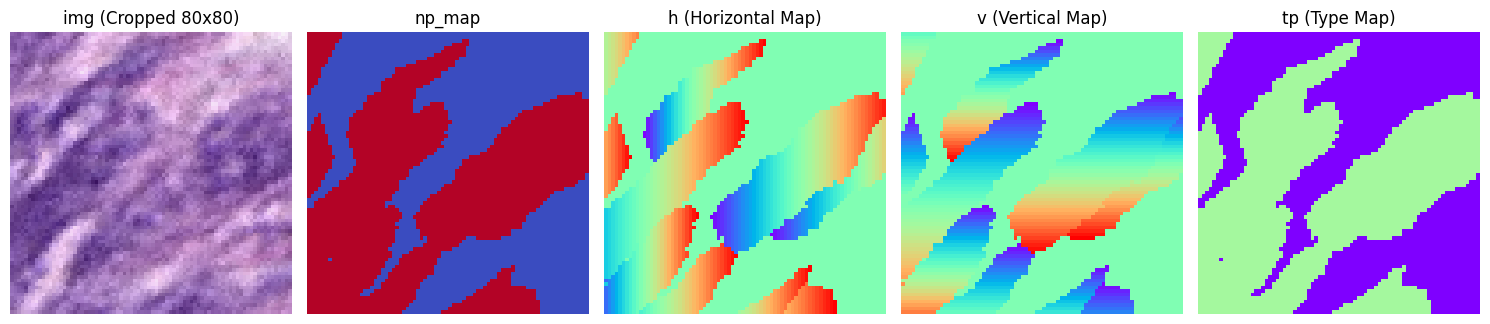

In [45]:
visualize_sample(train_dataset, index=20)